In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [5]:

# 定义要下载的股票代码
tickers = ["BZ=F", "NG=F"]
ohlcv_data = {}

# 设置数据的时间范围和时间间隔
period = '1y'  # 一年的数据
interval = '1h'  # 每小时的数据，如果需要最近7天的每分钟数据，可以改为 '1m'

for ticker in tickers:
    try:
        # 下载数据
        temp = yf.download(ticker, period=period, interval=interval)
        # 检查并删除包含任何NaN值的行
        temp.dropna(how="any", inplace=True)
        
        # 检查数据是否为空
        if temp.empty:
            print(f"No data available for {ticker}. Check ticker symbol or increase period/interval.")
        else:
            ohlcv_data[ticker] = temp
            print(f"Data for {ticker} downloaded successfully and contains {len(temp)} data points.")
    except Exception as e:
        print(f"Failed to download data for {ticker}: {e}")


[*********************100%%**********************]  1 of 1 completed


Data for BZ=F downloaded successfully and contains 5321 data points.


[*********************100%%**********************]  1 of 1 completed

Data for NG=F downloaded successfully and contains 5627 data points.


In [10]:
# 选择特征和目标变量
# 这里我们简单使用价格的滚动平均和RSI作为特征
features = ['Open', 'High', 'Low', 'Close', 'Volume']
ohlcv_data['BZ=F']['SMA'] = ohlcv_data['BZ=F']['Close'].rolling(window=24).mean()
ohlcv_data['BZ=F']['RSI'] = ohlcv_data['BZ=F']['Close'].rolling(window=24).apply(lambda x: np.mean(x))

# 使用滞后价格作为特征
ohlcv_data['BZ=F']['Lag1'] = ohlcv_data['BZ=F']['Close'].shift(1)

# 清理数据
ohlcv_data['BZ=F'].dropna(inplace=True)

X = ohlcv_data['BZ=F'][['SMA', 'RSI', 'Lag1']]
y = ohlcv_data['BZ=F']['Close']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 初始化模型
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_lr = LinearRegression()

# 训练模型
model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_lr.fit(X_train, y_train)

In [ ]:
# 进行预测
pred_rf = model_rf.predict(X_test)
pred_gb = model_gb.predict(X_test)
pred_lr = model_lr.predict(X_test)

# 集成预测结果
predictions_ensemble = (pred_rf + pred_gb + pred_lr) / 3

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 计算评估指标
mse = mean_squared_error(y_test, predictions_ensemble)
rmse = np.sqrt(mean_squared_error(y_test, predictions_ensemble))
mape = mean_absolute_percentage_error(y_test, predictions_ensemble)

print(f'均方误差（MSE）: {mse}')
print(f'均方根误差（RMSE）: {rmse}')
print(f'平均绝对百分比误差（MAPE）: {mape}%')


2

In [ ]:
# 假设'news'列包含新闻文本数据
vectorizer = CountVectorizer(max_features=100)
X_text = vectorizer.fit_transform(data['news']).toarray()

# 应用PCA进行降维
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_text)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# 将PCA结果合并回主数据集
for i in range(X_pca.shape[1]):
    data[f'pca_{i}'] = X_pca[:, i]

In [22]:
# Assuming X_test is your input DataFrame and it has been properly scaled/normalized if necessary
X_test_array = X_test.values  # Convert DataFrame to Numpy array

# Reshape the input for LSTM [samples, time steps, features]
# Here we assume each sample is a sequence of 1 time step with multiple features
X_test_reshaped = X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))
X_train_reshaped = X_train.values.reshape(-1, 1, 3)  # 1 time step, 3 features
print("Shape of X_train used for training:", X_train.shape)
print("Shape of X_test used for prediction:", X_test_reshaped.shape)


Shape of X_train used for training: (4238, 3)
Shape of X_test used for prediction: (1060, 1, 3)


In [24]:
# 随机森林和梯度提升机
model_rf = RandomForestRegressor(n_estimators=100)
model_gb = GradientBoostingRegressor(n_estimators=100)

# 支持向量机和线性回归
model_svr = SVR()
model_lr = LinearRegression()

# LSTM网络
# Define the LSTM model
model_lstm = Sequential([
    LSTM(50, input_shape=(1, 3)),  # Adjusted to 1 time step, 3 features
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')


# 训练模型（此处假设已完成数据预处理和划分）
model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_svr.fit(X_train, y_train)
model_lr.fit(X_train, y_train)
model_lstm.fit(X_train_reshaped, y_train, epochs=50, batch_size=32)

c:\Users\warre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - loss: 6625.0078
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 5743.2852
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 5171.1343
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 4663.5562
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 4243.2432
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 3859.6533
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 3449.2876
Epoch 8/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 3090.2991
Epoch 9/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 2769.9514
Epoch 10/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 2468.2561
Epoch 11/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 2203.3972
Epoch 12/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 1966.9242
Epoch 13/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 1736.8628
Epoch 14/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - los

In [25]:

predictions_rf = model_rf.predict(X_test)
predictions_gb = model_gb.predict(X_test)
predictions_svr = model_svr.predict(X_test)
predictions_lr = model_lr.predict(X_test)
#predictions_lstm = model_lstm.predict(X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))).flatten()
predictions_lstm = model_lstm.predict(X_test_reshaped).flatten()  # Predict and flatten the output
# 简单平均集成
predictions_ensemble = np.mean([predictions_rf, predictions_gb, predictions_svr, predictions_lr, predictions_lstm], axis=0)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [31]:
## 加权平均
# 计算各个模型的MSE，然后用MSE的倒数作为权重的基础
weights = [
    1 / mean_squared_error(y_test, predictions_rf),
    1 / mean_squared_error(y_test, predictions_gb),
    1 / mean_squared_error(y_test, predictions_svr),
    1 / mean_squared_error(y_test, predictions_lr),
    1 / mean_squared_error(y_test, predictions_lstm)
]

# 归一化权重
normalized_weights = [weight / sum(weights) for weight in weights]

# 计算加权平均预测
predictions_ensemble = (predictions_rf * normalized_weights[0] +
                        predictions_gb * normalized_weights[1] +
                        predictions_svr * normalized_weights[2] +
                        predictions_lr * normalized_weights[3] +
                        predictions_lstm * normalized_weights[4])


In [38]:
# 将所有模型的预测结果组合成新的特征集
stacked_features = np.column_stack((predictions_rf, predictions_gb, predictions_svr, predictions_lr, predictions_lstm))

# 划分新的训练集和测试集
stacked_X_train, stacked_X_test, stacked_y_train, stacked_y_test = train_test_split(stacked_features, y_test, test_size=0.2, random_state=42)

# 训练元模型
meta_model = LinearRegression()
meta_model.fit(stacked_X_train, stacked_y_train)

# 使用元模型进行预测
predictions_ensemble = meta_model.predict(stacked_X_test)


# 验证预测长度与y_test长度
print(f"Predicted length: {len(predictions_ensemble)}, Actual length: {len(stacked_y_test)}")

# 确保长度相同后，计算指标
if len(predictions_ensemble) == len(stacked_y_test):
    mse = mean_squared_error(stacked_y_test, predictions_ensemble)
    print(f"MSE: {mse}")
else:
    print("Error: Length of predictions does not match length of actual values.")

Predicted length: 212, Actual length: 212
MSE: 0.06566631070600239


In [39]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 计算评估指标
mse = mean_squared_error(y_test, predictions_ensemble)
rmse = np.sqrt(mean_squared_error(y_test, predictions_ensemble))
mae = mean_absolute_error(y_test, predictions_ensemble)
mape = mean_absolute_percentage_error(y_test, predictions_ensemble)

print(f'均方误差（MSE）: {mse}')
print(f'均方根误差（RMSE）: {rmse}')
print(f'MAE: {mae}')
print(f'平均绝对百分比误差（MAPE）: {mape}%')


ValueError: Found input variables with inconsistent numbers of samples: [1060, 212]

ValueError: x and y must have same first dimension, but have shapes (1060,) and (212,)

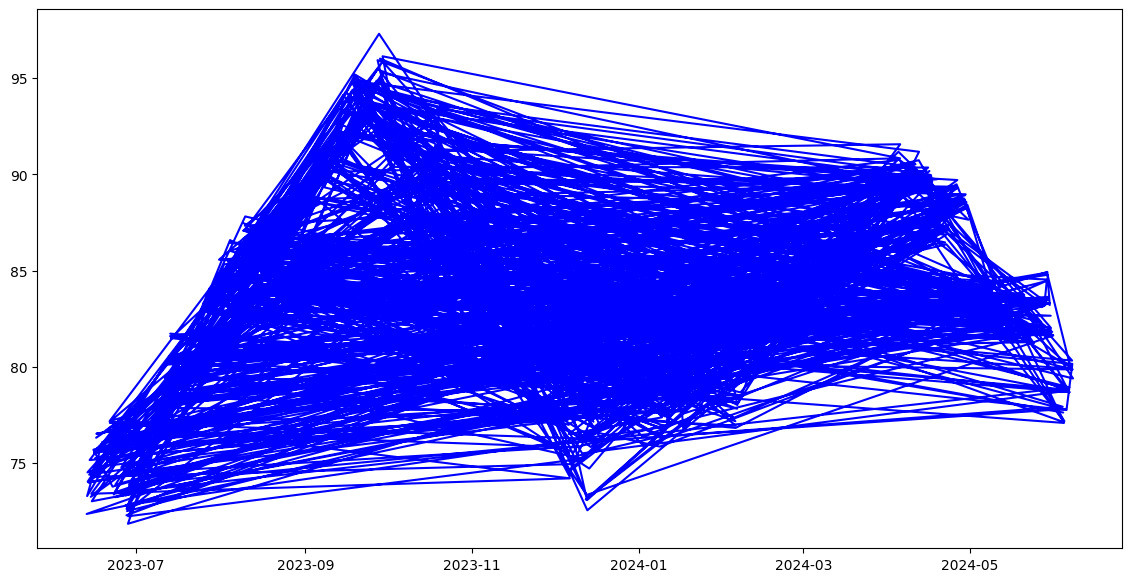

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Price', color='blue')
plt.plot(y_test.index, predictions_ensemble, label='Predicted Price', linestyle='--', color='red')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()